[View in Colaboratory](https://colab.research.google.com/github/neoaksa/Distracted_Driver_Detection/blob/master/Distracted_Driver_Detection.ipynb)

Distracted Driver images are from kaggle competiton which you can find detail [here](https://www.kaggle.com/c/state-farm-distracted-driver-detection#description).

Basicly, the data alrealy labeled into 10 different statues, from C0 to C9. 
- c0: normal driving
- c1: texting - right
- c2: talking on the phone - right
- c3: texting - left
- c4: talking on the phone - left
- c5: operating the radio
- c6: drinking
- c7: reaching behind
- c8: hair and makeup
- c9: talking to passenger 

we know it is a supervised learning problem and there are bunch of solutions for this problem in kaggle. But I still want to implent it as I need to build a standard pipline for this kind of issue and try variety model by keras to achieve the best result basis of  multi-class logarithmic loss.   

**Step 1**: the first setp is simple, download the raw data from google drive and unzip the image folder. This might take a while since the image zip file are almost 4Gb. Compressed file :https://drive.google.com/file/d/1OA94GnqYDD9O4NPxepRot4-whIYYC62S/view?usp=sharing
 Plus: you will love Google componets, the uncompress process is super faster than your own pc.

In [13]:
! pip install pydrive
# these classes allow you to request the Google drive API
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials
from googleapiclient.discovery import build
from google.colab import auth
import zipfile

# authenticate google drive
auth.authenticate_user()
drive_service = build('drive', 'v3')
# 1. Authenticate and create the PyDrive client.
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def downloadFile(inputfilename,outputfilename):
    downloaded = drive.CreateFile({'id': inputfilename})
    # assume the file is called file.csv and it's located at the root of your drive
    downloaded.GetContentFile(outputfilename)
    
# traning file download
FileObj = downloadFile("1OA94GnqYDD9O4NPxepRot4-whIYYC62S","all.zip")

# unzip files
zip_ref = zipfile.ZipFile('all.zip', 'r')
zip_ref.extractall('./')
zip_ref.close()
# unzip images
zip_ref = zipfile.ZipFile('imgs.zip', 'r')
zip_ref.extractall('./imgs/')
zip_ref.close()

# check the dictory
import os
for x in os.listdir('./'):
    print(x)

datalab
sample_data
.config
all.zip
sample_submission.csv
imgs
adc.json
imgs.zip
driver_imgs_list.csv


So, we got the raw data we need. 
- *driver_imgs_list.csv* is the label information. 
- *imgs* is the folder for storing images by classifications
- *sample_submission.csv* is the submission format, we can leave it alone.

**Step 2**: Before we do any data analysis, we need to overview the whole dataset, such as distribution of samples or take a peek of images by each classification.

c0    2489
c3    2346
c4    2326
c6    2325
c2    2317
c5    2312
c1    2267
c9    2129
c7    2002
c8    1911
Name: classname, dtype: int64


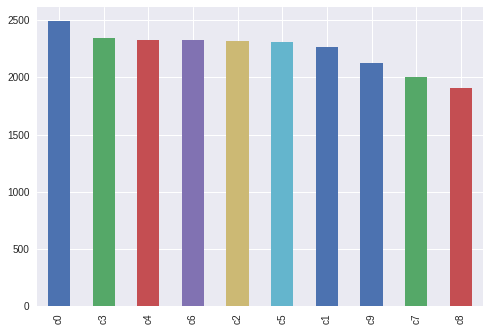

In [40]:
import pandas as pd

# load data from  driver_imgs_list.csv
df_all = pd.read_csv('driver_imgs_list.csv')
print(df_all['classname'].value_counts())
df_all['classname'].value_counts().plot(kind='bar')

The number of each category shows they are balance. Otherwise, wehave to rebalance samples by ADASYN or SMOTE.

In [61]:
# let's see how many samples in traing and testing folders
print('train sample #:'+ str(sum([len(files) for r, d, files in os.walk('./imgs/train')])))
print('test sample #:' + str(sum([len(files) for r, d, files in os.walk('./imgs/test')])))

train sample #:22424
test sample #:79726


**Step 3**: we will use a** Convolution Neural Network** for the task. However, we don't have to build a new CNN from begining. Alternatively, we will use pre-trained ImageNet models for this task and do some transfer learning through keras.

In [0]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

img_width, img_height = 256, 256
train_data_dir = "data/train"
validation_data_dir = "data/val"
nb_train_samples = 4125
nb_validation_samples = 466 
batch_size = 16
epochs = 50

# VGG19 model
model = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))
# Freeze the first 5 layers(Cov layers), and only train FC layer
for layer in model.layers[:5]:
    layer.trainable = False

#Adding custom Layers 
x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(16, activation="softmax")(x)

# creating the final model 
model_final = Model(input = model.input, output = predictions)

# compile the model 
model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

# Initiate the train and test generators with data Augumentation 
train_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.3,
width_shift_range = 0.3,
height_shift_range=0.3,
rotation_range=30)

test_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.3,
width_shift_range = 0.3,
height_shift_range=0.3,
rotation_range=30)

train_generator = train_datagen.flow_from_directory(
train_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size, 
class_mode = "categorical")

validation_generator = test_datagen.flow_from_directory(
validation_data_dir,
target_size = (img_height, img_width),
class_mode = "categorical")

# Save the model according to the conditions  
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')


# Train the model 
model_final.fit_generator(
train_generator,
samples_per_epoch = nb_train_samples,
epochs = epochs,
validation_data = validation_generator,
nb_val_samples = nb_validation_samples,
callbacks = [checkpoint, early])